# Book Recommendation System (Collaborative Filtering)

This recommendation system is based on collaborative filtering, which, unlike the content similarity recommendation system, needs users to give ratings to the books they read, indicating if they liked it or not.

This way, the recommendation system can recommend books that users may like, based on the ratings from users with a similar taste (e.g. if both user A and B like fantasy books and user B just read a new fantasy book that he loved, there's a high probability that user A might like it as well).

Based on the following projects [#1](https://www.kaggle.com/jirakst/book-recommendation/notebook) and [#2](https://www.youtube.com/watch?v=3ecNC-So0r4).

Dataset obtained from the following Kaggle [link](https://www.kaggle.com/jirakst/bookcrossing).

### 0. Load Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Ignore Pandas warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1. Load Data

In [2]:
users = pd.read_csv("data/collaborative_filtering/BX-Users.csv", delimiter=";", encoding="ISO-8859-1")
books = pd.read_csv("data/collaborative_filtering/BX-Books.csv", delimiter=";", encoding="ISO-8859-1", error_bad_lines=False, warn_bad_lines=False)
ratings = pd.read_csv('data/collaborative_filtering/BX-Book-Ratings.csv', delimiter=";", encoding = "ISO-8859-1")

/Users/eduardosilva/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Merge the datasets, based on each dataset's primary keys, similar to how inner joins work in SQL
data = pd.merge(ratings, users, on="User-ID", how="inner")
data = pd.merge(data, books, on="ISBN", how="inner")

data.columns

Index(['User-ID', 'ISBN', 'Book-Rating', 'Location', 'Age', 'Book-Title',
       'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S',
       'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [4]:
# Drop images, as they are not needed for this study
to_drop = ['Image-URL-S', 'Image-URL-M', 'Image-URL-L']
data = data.drop(to_drop, axis=1, inplace=False)

### 2. Exploratory Data Analysis

#### 2.1. Overview

In [5]:
data.head()

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,"tyler, texas, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,2313,034545104X,5,"cincinnati, ohio, usa",23.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
2,6543,034545104X,0,"strafford, missouri, usa",34.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
3,8680,034545104X,5,"st. charles county, missouri, usa",2.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
4,10314,034545104X,9,"beaverton, oregon, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books


In [6]:
print('Missing data [%]')
round(data.isnull().sum() / len(data) * 100, 4)

Missing data [%]


User-ID                 0.0000
ISBN                    0.0000
Book-Rating             0.0000
Location                0.0000
Age                    26.9446
Book-Title              0.0000
Book-Author             0.0001
Year-Of-Publication     0.0000
Publisher               0.0002
dtype: float64

#### 2.2. User Analysis

In [7]:
print('Number of users: ',data['User-ID'].nunique())

Number of users:  92106


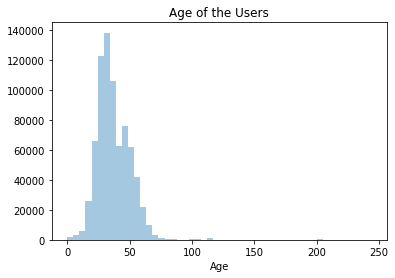

In [8]:
sns.distplot(data["Age"].dropna(), kde=False, label="Age").set_title("Age of the Users")
plt.show()

In [9]:
outliers = sum(data["Age"] > 100)
print(f"There seem to be {outliers} people that are more than 100 years old.")

There seem to be 2910 people that are more than 100 years old.


In [10]:
countries = data["Location"].apply(lambda row: str(row).split(",")[-1])
country_count = data.groupby(countries)["Book-Rating"].count().sort_values(ascending=False).head(10)

print("Countries with most reviews:")
country_count

Countries with most reviews:


Location
 usa               746466
 canada             93000
 united kingdom     33072
 germany            27657
                    24259
 australia          18238
 spain              14968
 n/a                11177
 france             10639
 portugal            6980
Name: Book-Rating, dtype: int64

#### 2.3. Book Analysis

In [11]:
# Set missing ratings to 0
data['Book-Rating'] = data['Book-Rating'].replace(0, None)

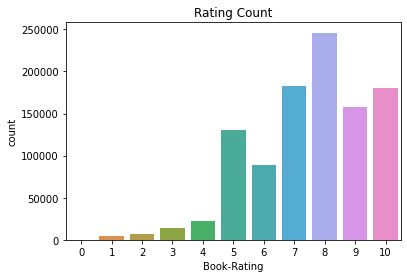

In [12]:
sns.countplot(x='Book-Rating', data=data).set_title("Rating Count")
plt.show()

In [13]:
print('Average book rating: ', round(data['Book-Rating'].mean(), 2))

Average book rating:  7.55


In [14]:
reviews_count = data["Book-Title"].value_counts()[:10]

print("Books with highest number of reviews:")
reviews_count

Books with highest number of reviews:


Wild Animus                                        2502
The Lovely Bones: A Novel                          1295
The Da Vinci Code                                   898
A Painted House                                     838
The Nanny Diaries: A Novel                          828
Bridget Jones's Diary                               815
The Secret Life of Bees                             774
Divine Secrets of the Ya-Ya Sisterhood: A Novel     740
The Red Tent (Bestselling Backlist)                 723
Angels &amp; Demons                                 670
Name: Book-Title, dtype: int64

In [15]:
book_count = data["Book-Author"].value_counts()[:10]

print("Authors with most books:")
book_count

Authors with most books:


Stephen King          10053
Nora Roberts           8429
John Grisham           6010
James Patterson        5845
Mary Higgins Clark     4777
Dean R. Koontz         4313
Tom Clancy             4036
Danielle Steel         3726
Sue Grafton            3457
Janet Evanovich        3350
Name: Book-Author, dtype: int64

### 3. Prepare Data

In [16]:
# Change year of publication to a numeric value
data['Year-Of-Publication'] = pd.to_numeric(data['Year-Of-Publication'], 'coerce').fillna(2099, downcast = 'infer')

In [17]:
# Remove age outliers
data['Age'] = np.where(data['Age']>90, None, data['Age'])

In [18]:
# Replace NA reviews by 0
data['Book-Rating'] = data['Book-Rating'].replace(0, None)

In [19]:
# Replace NA authors and publishers by 'Unknown'
data[['Book-Author', 'Publisher']] = data[['Book-Author', 'Publisher']].fillna('Unknown')

In [20]:
# Replace location by Country, as it is more relevant than the full location
data['Country'] = data['Location'].apply(lambda row: str(row).split(',')[-1])
data = data.drop('Location', axis=1)

### 4. Testing

In [60]:
# A small list of books was chosen, to simplify the test. In practice, 
# a much larger set of books would be available, making this approach less feasible. 
# Techniques such as clustering could be useful here, as it would allow us to subset 
# the books and users into smaller sets.

sample_book_list = ["1984", "American Gods", "Anna Karenina", "Dune", "To Kill a Mockingbird", 
                    "War and Peace", "The Da Vinci Code", "The Godfather", "The Shining", "Pride and Prejudice",
                    "Crime and Punishment", "We", "Brave New World", "Fahrenheit 451", "Animal Farm", "Twilight",
                    "The Fellowship of the Ring (The Lord of the Rings, Part 1)", 
                    "The Two Towers (The Lord of the Rings, Part 2)",
                    "The Return of the King (The Lord of the Rings, Part 3)"]

data_sample = data[data["Book-Title"].isin(sample_book_list)]

pivot = data_sample.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating').fillna(0)

pivot

Book-Title,1984,American Gods,Animal Farm,Anna Karenina,Brave New World,Crime and Punishment,Dune,Fahrenheit 451,Pride and Prejudice,The Da Vinci Code,"The Fellowship of the Ring (The Lord of the Rings, Part 1)",The Godfather,"The Return of the King (The Lord of the Rings, Part 3)",The Shining,"The Two Towers (The Lord of the Rings, Part 2)",To Kill a Mockingbird,Twilight,War and Peace,We
User-ID,,,,,,,,,,,,,,,,,,,
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,9.0,10.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278418,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
278422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
278550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
corr_pivot = pivot.corr(method="pearson")
corr_pivot

Book-Title,1984,American Gods,Animal Farm,Anna Karenina,Brave New World,Crime and Punishment,Dune,Fahrenheit 451,Pride and Prejudice,The Da Vinci Code,"The Fellowship of the Ring (The Lord of the Rings, Part 1)",The Godfather,"The Return of the King (The Lord of the Rings, Part 3)",The Shining,"The Two Towers (The Lord of the Rings, Part 2)",To Kill a Mockingbird,Twilight,War and Peace,We
Book-Title,,,,,,,,,,,,,,,,,,,
1984,1.000000,-0.027074,0.080287,-0.002101,0.118211,0.013056,-0.021716,0.011071,-0.011602,-0.093854,-0.033125,-0.032599,-0.018367,-0.006674,-0.008797,-0.025532,-0.017822,0.001912,0.016537
American Gods,-0.027074,1.000000,-0.002635,-0.026892,0.019586,-0.013769,-0.010851,-0.022370,-0.030381,-0.104765,-0.038918,-0.010987,-0.034744,-0.034296,-0.030929,-0.036114,-0.002127,-0.008429,0.008426
Animal Farm,0.080287,-0.002635,1.000000,0.029649,0.056678,-0.011850,-0.014470,0.034214,-0.008139,-0.121734,-0.013649,0.041424,0.001263,0.006971,0.013100,0.014808,-0.015914,-0.012713,0.010637
Anna Karenina,-0.002101,-0.026892,0.029649,1.000000,0.017650,-0.004461,0.058115,-0.014092,0.032843,-0.051254,-0.031247,0.030075,-0.017681,-0.006503,-0.022169,0.013318,-0.005991,0.092912,-0.009765
Brave New World,0.118211,0.019586,0.056678,0.017650,1.000000,0.023954,0.025023,0.063798,0.006794,-0.071291,-0.004743,-0.001324,0.041762,-0.007227,0.024185,0.007040,-0.015358,0.021457,0.033549
Crime and Punishment,0.013056,-0.013769,-0.011850,-0.004461,0.023954,1.000000,-0.006882,0.054978,-0.010282,-0.005393,-0.015120,0.104704,-0.011309,-0.008799,-0.012647,-0.018363,-0.002289,-0.003995,-0.003731
Dune,-0.021716,-0.010851,-0.014470,0.058115,0.025023,-0.006882,1.000000,0.005609,0.026799,-0.044035,0.017933,0.005943,0.041575,0.003529,0.018678,0.008135,-0.009242,0.009084,0.000158
Fahrenheit 451,0.011071,-0.022370,0.034214,-0.014092,0.063798,0.054978,0.005609,1.000000,-0.012603,-0.139367,-0.043407,-0.006444,-0.023307,-0.011867,-0.042415,-0.001961,-0.001680,0.005181,-0.000025
Pride and Prejudice,-0.011602,-0.030381,-0.008139,0.032843,0.006794,-0.010282,0.026799,-0.012603,1.000000,-0.068241,-0.024090,0.016806,-0.012625,-0.013964,-0.027577,0.021721,-0.013807,0.040179,0.001061


In [94]:
def recommend_books(book_name, user_rating):
    similar_score = corr_pivot[book_name] * (user_rating - 5)
    similar_score = similar_score.sort_values(ascending=False)
    
    return similar_score

def recommend_books_multiple(books):
    recommendations = pd.DataFrame()

    for book, rating in my_books:
        recommendations = recommendations.append(recommend_books(book, rating), ignore_index=True)

    filtered_rec = recommendations[recommendations.columns.difference(book[0] for book in my_books)]
    sorted_rec = filtered_rec.sum().sort_values(ascending=False)

    return sorted_rec

In [104]:
my_books = [("Anna Karenina", 10), ("1984", 9), ("Twilight", 4), ("Fahrenheit 451", 7), ("Animal Farm", 9)]

top5 = recommend_books_multiple(my_books)[:5].index.tolist()

print("Here are some books you might like:")
for num, book in enumerate(top5):
    print(f"{num + 1}. {book}")

Here are some books you might like:
1. Brave New World
2. War and Peace
3. The Godfather
4. Dune
5. Crime and Punishment


**Not bad! I've been wanting to read these books for a while!**